In [1]:
from tensorflow.keras.applications import Xception
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
from tensorflow.keras.models import  Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Activation, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception

# Task

The task concerns the problem of image classification of sign language digits.

https://www.kaggle.com/ardamavi/sign-language-digits-dataset

In [2]:
X = np.load('dataset/X.npy')
y = np.load('dataset/Y.npy')
img_size = 64

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

X_test = X_test[:,:,:,np.newaxis]
X_train = X_train[:,:,:,np.newaxis]

def visualize_digits():
    image_index_list = [260, 900, 1800, 1600, 1400, 2061, 700, 500, 1111, 100]

    for number in range(10):
        plt.figure(figsize=(8,5))
        number_image = x_load[image_index_list[number]]
        plt.imshow(number_image.reshape(img_size, img_size), cmap="gray")
        title = "Sign " + str(number) 
        plt.title(title)
    plt.show()
    
def visualize_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

# Basic CNN

In [3]:
target_size = (64, 64)
batch_size = 32

training_steps = len(X_train) // batch_size
validation_steps = len(X_test) // batch_size

In [4]:
def build_base_cnn_model():
    model = Sequential()
    model.add(Conv2D(input_shape=(64, 64, 1), filters=64, kernel_size=(4,4), strides=(2)))
    model.add(Activation('relu'))
    model.add(Conv2D(filters=64, kernel_size=(4,4), strides=(1)))
    model.add(MaxPooling2D(pool_size=4))
    model.add(Dropout(0.3))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(10, activation='softmax'))
    model.compile(
        optimizer = 'adam', 
        loss = 'categorical_crossentropy', 
        metrics = ['accuracy']
    )
    return model

base_cnn_model = build_base_cnn_model()
base_cnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 31, 31, 64)        1088      
_________________________________________________________________
activation (Activation)      (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        65600     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 7, 7, 64)          0         
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1

## ImageDataGenerator for base case

Epoch 1/30
48/48 [==============================] - 13s 279ms/step - loss: 1.3920 - accuracy: 0.5568 - val_loss: 1.8631 - val_accuracy: 0.6328
Epoch 2/30
48/48 [==============================] - 14s 282ms/step - loss: 0.6511 - accuracy: 0.7906 - val_loss: 1.7080 - val_accuracy: 0.7559
Epoch 3/30
48/48 [==============================] - 14s 288ms/step - loss: 0.4247 - accuracy: 0.8581 - val_loss: 1.5217 - val_accuracy: 0.6953
Epoch 4/30
48/48 [==============================] - 13s 271ms/step - loss: 0.2658 - accuracy: 0.9182 - val_loss: 1.0175 - val_accuracy: 0.8535
Epoch 5/30
48/48 [==============================] - 13s 275ms/step - loss: 0.2274 - accuracy: 0.9221 - val_loss: 0.9015 - val_accuracy: 0.8789
Epoch 6/30
48/48 [==============================] - 13s 278ms/step - loss: 0.1385 - accuracy: 0.9616 - val_loss: 0.6312 - val_accuracy: 0.8711
Epoch 7/30
48/48 [==============================] - 13s 271ms/step - loss: 0.1632 - accuracy: 0.9477 - val_loss: 0.3788 - val_accuracy: 0.9121

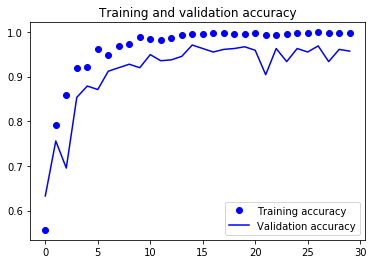

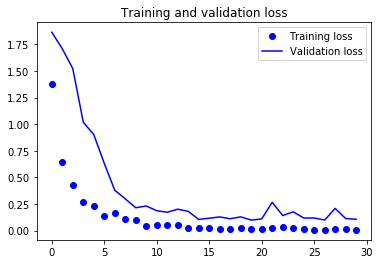

In [5]:
def get_train_test_generator():
    train_datagen = ImageDataGenerator()
    test_datagen = ImageDataGenerator()

    train_generator = train_datagen.flow(
        X_train,
        y_train,
        batch_size=batch_size,
    )

    validation_generator = test_datagen.flow(
        X_test,
        y_test,
        batch_size=batch_size,
    )
    return train_generator, validation_generator

train_generator, validation_generator = get_train_test_generator()


history_cnn = base_cnn_model.fit_generator(
    train_generator,  
    steps_per_epoch=training_steps,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=validation_steps
)

base_cnn_model.save("base_cnn_model.h5")
visualize_history(history_cnn)

In [6]:
def perform_test():
    correct_guesses = 0
    number_of_samples = 1

    for i in range(len(X_test)):
        img_to_show = X_test[i]
        labels = y_test[i]
        max_label = labels.argmax()
        img_to_predict = img_to_show[np.newaxis,:,:,:]
        prediction = model.predict(img_to_predict)
        max_pred = prediction.argmax()

        if max_label == max_pred:
            correct_guesses +=1
    print(f"Correctly predicted {correct_guesses}/{number_of_samples}")

# Basic CNN with Data Augmentation
## ImageDataGenerator with Data Augmentation

Epoch 1/30
48/48 [==============================] - 14s 284ms/step - loss: 2.7102 - accuracy: 0.1400 - val_loss: 2.1751 - val_accuracy: 0.1895
Epoch 2/30
48/48 [==============================] - 15s 317ms/step - loss: 2.1307 - accuracy: 0.2845 - val_loss: 2.1884 - val_accuracy: 0.0957
Epoch 3/30
48/48 [==============================] - 14s 294ms/step - loss: 1.7634 - accuracy: 0.3948 - val_loss: 2.0812 - val_accuracy: 0.4062
Epoch 4/30
48/48 [==============================] - 13s 273ms/step - loss: 1.4668 - accuracy: 0.4993 - val_loss: 1.9437 - val_accuracy: 0.3711
Epoch 5/30
48/48 [==============================] - 13s 276ms/step - loss: 1.2679 - accuracy: 0.5806 - val_loss: 1.7425 - val_accuracy: 0.4238
Epoch 6/30
48/48 [==============================] - 13s 272ms/step - loss: 1.1427 - accuracy: 0.6116 - val_loss: 1.5750 - val_accuracy: 0.4648
Epoch 7/30
48/48 [==============================] - 13s 271ms/step - loss: 0.9541 - accuracy: 0.6823 - val_loss: 1.2758 - val_accuracy: 0.6602

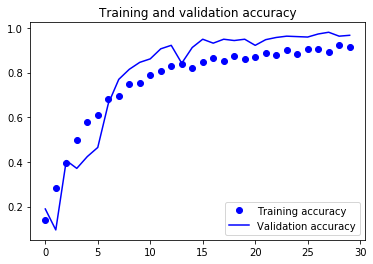

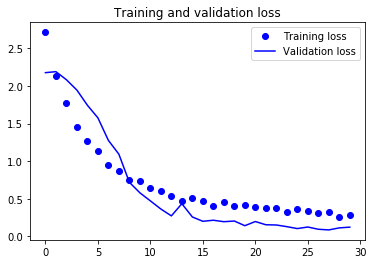

In [8]:
def get_train_test_generator_augmented():
    train_datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
    )
    test_datagen = ImageDataGenerator()

    train_generator = train_datagen.flow(
        X_train,
        y_train,
        batch_size=batch_size,
    )

    validation_generator = test_datagen.flow(
        X_test,
        y_test,
        batch_size=batch_size,
    )

    return train_generator, validation_generator

train_generator, validation_generator = get_train_test_generator_augmented()

base_cnn_model_augmentation = build_base_cnn_model()

history_cnn_augmentation = base_cnn_model_augmentation.fit_generator(
    train_generator,
    steps_per_epoch=training_steps,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=validation_steps
)

base_cnn_model_augmentation.save("base_cnn_model_augmentation.h5")
visualize_history(history_cnn_augmentation)